## Multi-Kernel 1D CNN으로 네이버 영화 리뷰 분류

In [1]:
import tensorflow as tf

In [ ]:
pip install konlpy

<br>

#### 데이터 로드 & 전처리

In [3]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fe0101813f0>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print('훈련 샘플의 개수 :',len(train_data))
print('테스트 샘플의 개수 :',len(test_data))

훈련 샘플의 개수 : 150000
테스트 샘플의 개수 : 50000


In [7]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

<br>

#### document 열에서 중복인 내용이 있다면 중복 제거

In [10]:
train_data.drop_duplicates(subset=['document'], inplace=True)

print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<br>

#### Null 값이 존재하는 행 제거

In [11]:
train_data = train_data.dropna(how = 'any')

print(len(train_data))

146182


<br>

#### 한글과 공백을 제외하고 모두 제거

In [12]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-12-6948268dad63>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


<br>

#### white space 데이터를 empty value로 변경후 제거

In [13]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


<ipython-input-13-87710e8815e4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


In [15]:
train_data = train_data.dropna(how = 'any')

print(len(train_data))

145393


<br>

#### Test 데이터 전처리

In [16]:
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-16-bff3433ea713>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-16-bff3433ea713>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


In [18]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<br>

#### 불용어 제거

In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [20]:
okt = Okt()

In [21]:
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [11:25<00:00, 212.06it/s]


In [22]:
X_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [03:57<00:00, 205.39it/s]


In [23]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 48852


<br>

#### 토큰화

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [27]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [28]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [29]:
vocab_size = total_cnt - rare_cnt + 1

print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


<br>

#### 빈도수 2 이하인 단어는 제거

In [30]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [32]:
print(len(X_train))
print(len(y_train))

145393
145393


<br>

#### 길이가 1보다 작은 문장 제거

In [33]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [34]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [35]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

145162
145162
48852
48852


In [36]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print(len(X_test))
print(len(y_test))

48745
48745


<br>

#### 패딩

In [39]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [40]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


- 전체 데이터의 길이는 30으로 패딩

In [41]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

<br>

### Multi-Kernel 1D CNN 모델 구축

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [59]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [60]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

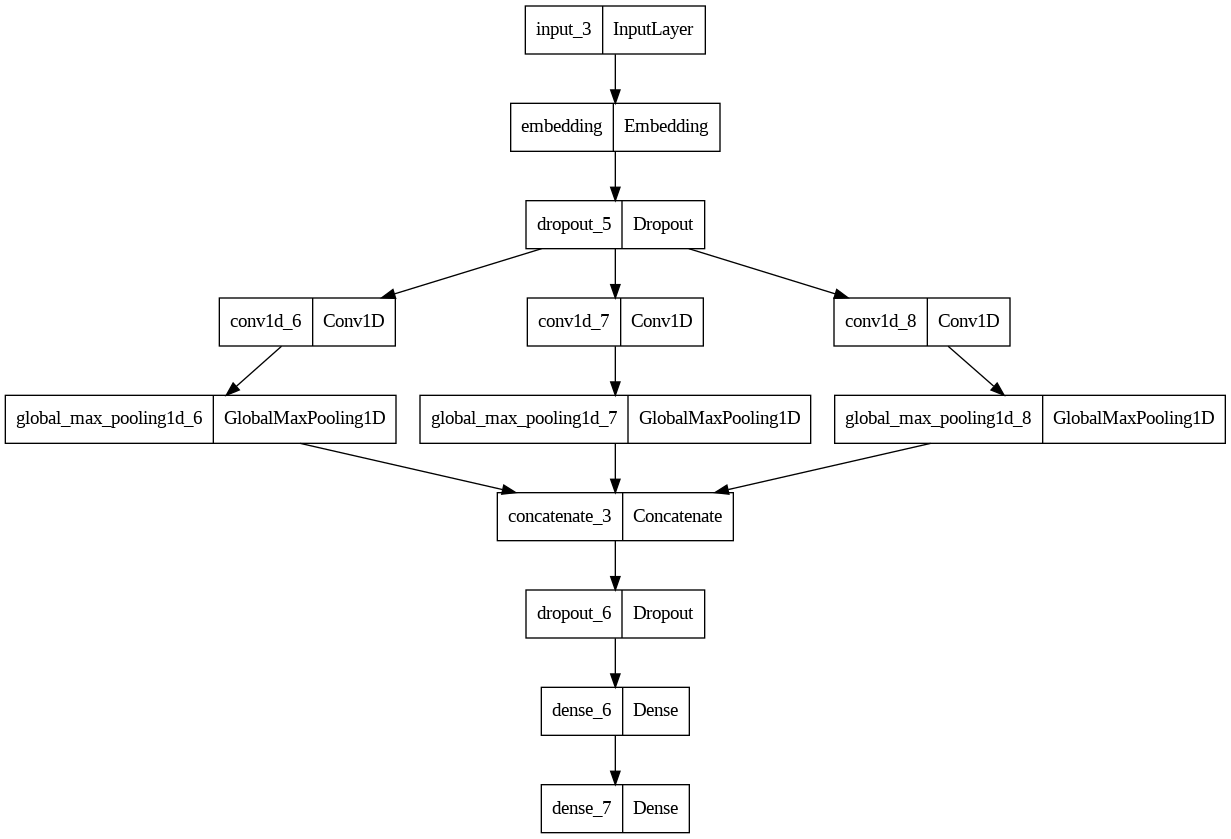

In [61]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)

plot_model(model)

In [62]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [64]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=False, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=10,
          validation_split = 0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10
1815/1815 - 57s - loss: 0.4383 - acc: 0.7883 - val_loss: 0.3680 - val_acc: 0.8424 - 57s/epoch - 31ms/step
Epoch 2/10
1815/1815 - 16s - loss: 0.3470 - acc: 0.8515 - val_loss: 0.3604 - val_acc: 0.8457 - 16s/epoch - 9ms/step
Epoch 3/10
1815/1815 - 12s - loss: 0.3147 - acc: 0.8666 - val_loss: 0.3558 - val_acc: 0.8461 - 12s/epoch - 7ms/step
Epoch 4/10
1815/1815 - 15s - loss: 0.2888 - acc: 0.8801 - val_loss: 0.3591 - val_acc: 0.8458 - 15s/epoch - 8ms/step
Epoch 5/10
1815/1815 - 12s - loss: 0.2696 - acc: 0.8890 - val_loss: 0.3617 - val_acc: 0.8460 - 12s/epoch - 7ms/step
Epoch 6/10
1815/1815 - 12s - loss: 0.2518 - acc: 0.8965 - val_loss: 0.3708 - val_acc: 0.8432 - 12s/epoch - 7ms/step
Epoch 7/10
1815/1815 - 12s - loss: 0.2378 - acc: 0.9035 - val_loss: 0.3826 - val_acc: 0.8414 - 12s/epoch - 7ms/step


<br>

#### 모델 평가

In [66]:
loaded_model = load_model('CNN_model.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1524/1524 [==============================] - 5s 3ms/step - loss: 0.3609 - acc: 0.8424

 테스트 정확도: 0.8424


<br>

#### 리뷰 예측

In [67]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [68]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 198ms/step
97.12% 확률로 부정 리뷰입니다.



In [69]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 19ms/step
72.43% 확률로 긍정 리뷰입니다.



<br>

<br>

## 사전 훈련된 워드 임베딩을 이용한 의도 분류(Intent Classification using Pre-trained Word Embedding)

In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

<br>

#### 데이터 로드

In [71]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [73]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


<br>

- 'add another song to the cita rom ntica playlist'라는 문장의 레이블은 'AddToPlaylist' : 이 곡을 플레이리스트에 추가해줘라는 의도

In [ ]:
print(intent_train[:5])
print(label_train[:5])

<br>

#### 데이터 확인
- 훈련 데이터에는 6개의 카테고리가 존재
  - AddToPlaylist, BookRestaurant, GetWeather , RateBook , SearchCreativeWork, SearchScreeningEvent
  - 각각의 데이터는 약 2,000개씩 존재

<Axes: >

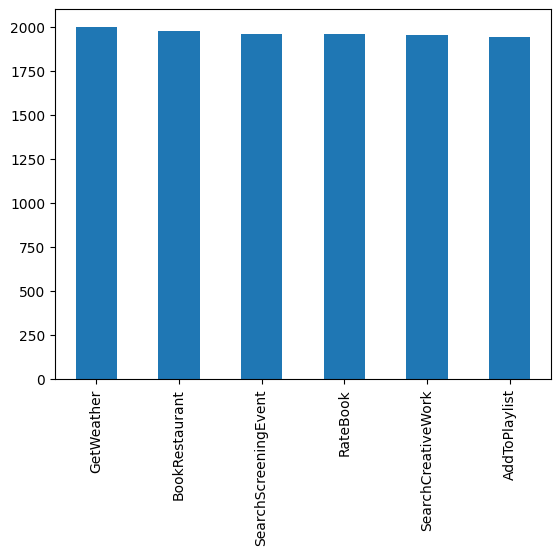

In [74]:
train_data['label'].value_counts().plot(kind = 'bar')

<br>

#### 라벨 인코딩
#### `sklearn.preprocessing.LabelEncoder()`

In [75]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

LabelEncoder()

In [76]:
label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test = idx_encode.transform(label_test) # 고유한 정수로 변환

In [78]:
label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
'레이블과 정수의 맵핑 관계 :',label_idx

('레이블과 정수의 맵핑 관계 :',
 {'AddToPlaylist': 0,
  'BookRestaurant': 1,
  'GetWeather': 2,
  'RateBook': 3,
  'SearchCreativeWork': 4,
  'SearchScreeningEvent': 5})

<br>

#### 토큰화 & 인코딩

In [79]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)

In [80]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


<br>

- 문장의 최대 길이는 35

문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


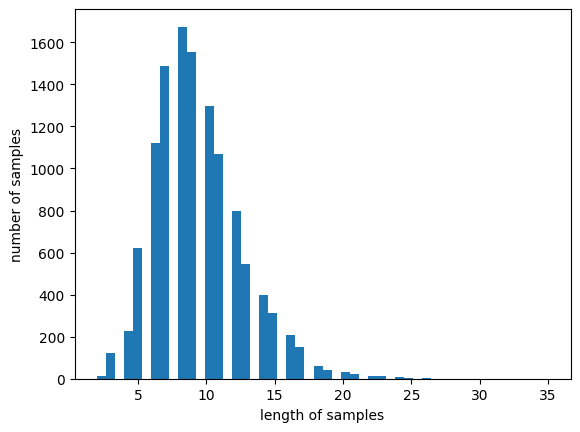

In [81]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))

plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [82]:
max_len = 35

intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))

print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


<br>

#### 훈련 데이터로부터 검증 데이터를 분리
- **검증 데이터로 분리하기 전에 훈련 데이터의 순서를 랜덤 Shuffle**


In [83]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)

print('랜덤 시퀀스 :',indices[:5])

랜덤 시퀀스 : [  83 2755 7047 6894 2670]


In [84]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [85]:
n_of_val = int(0.1 * intent_train.shape[0])

print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 1178


In [86]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]

X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]

X_test = intent_test
y_test = label_test

print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


<br>

### 사전 훈련된 워드 임베딩 사용

- 스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [88]:
embedding_dict = dict()

f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [89]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

<br>

#### 임베딩 테이블 구축
- **사전 훈련된 임베딩의 벡터의 차원이 100이므로 임베딩 테이블의 열도 100차원**
  - vocab_size를 행의 크기로, 열의 크기는 100인 테이블 생성

In [90]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


In [93]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

<br>

#### 1D CNN을 이용한 의도 분류 모델 구축

In [94]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.utils import plot_model

In [95]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

In [96]:
model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

In [97]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

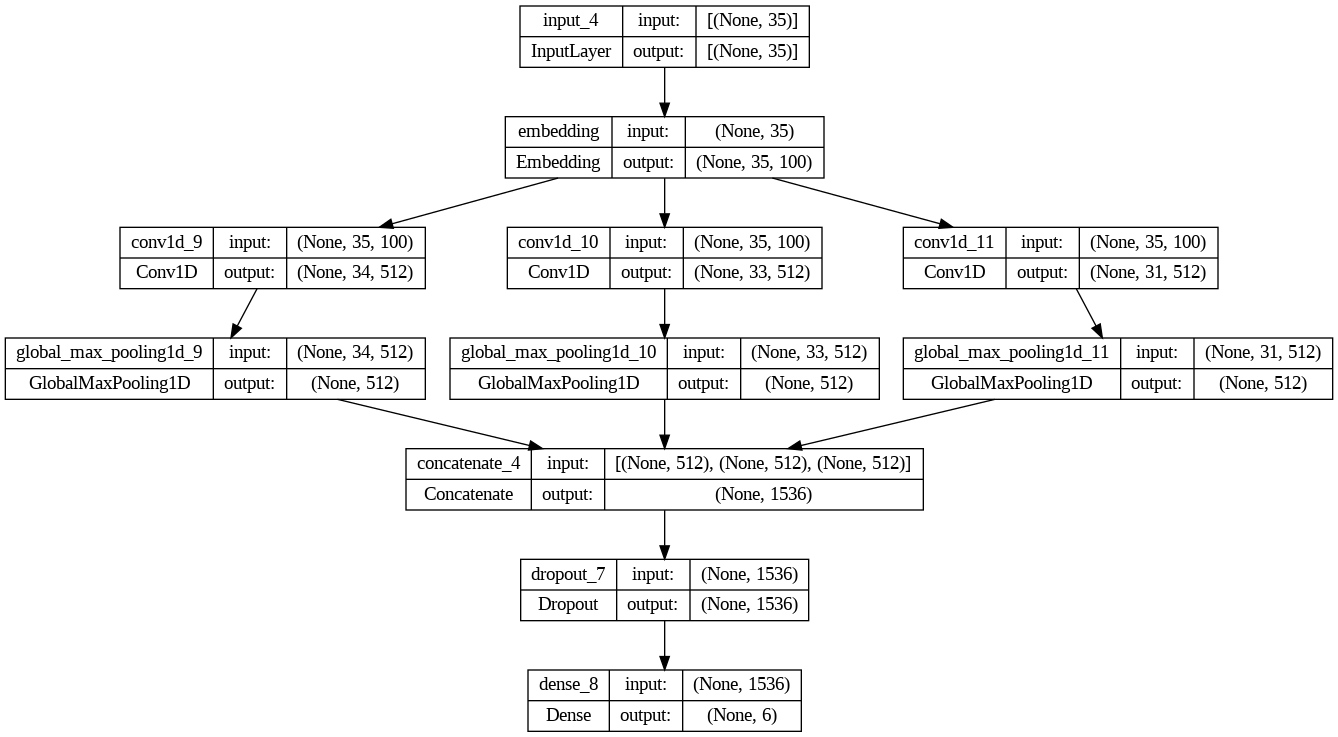

In [98]:
plot_model(model, show_shapes=True)

In [99]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_val, y_val), verbose=False)

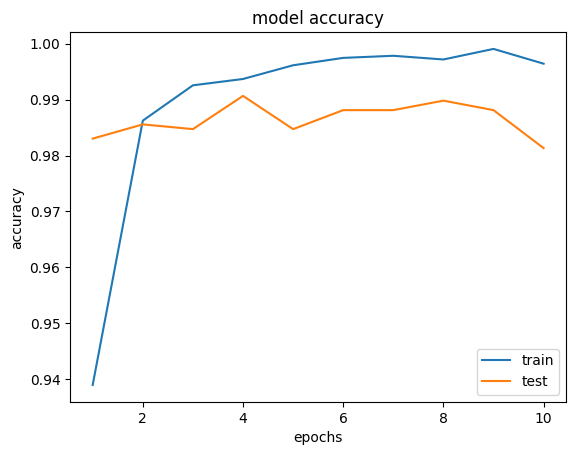

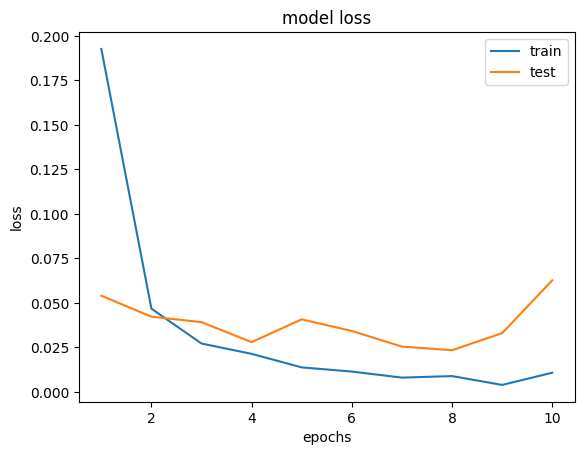

In [100]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

<br>

#### 모델 평가

In [101]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [102]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1)

19/19 [==============================] - 0s 6ms/step


In [103]:
print('정확도(Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도(Accuracy) :  0.99


<br>

<br>

## 문자 임베딩(Character Embedding)

- **문자 임베딩(Character Embedding) : 워드 임베딩과는 다른 방법으로 단어의 벡터 표현 방법을 얻는 방법**

```
'understand'라는 단어는 '이해하다'라는 뜻을 가진 영단어입니다.
그런데 여기에 mis-를 앞에 붙여주게 되면, 'misunderstand'라는 '오해하다'라는 뜻의 다른 의미의 영단어가 됩니다.
비슷한 예시를 들어보겠습니다.
'underestimate'라는 단어는 '과소평가하다'라는 단어입니다.
그렇다면 'misunderestimate'는 무슨 뜻일까요?
사실 이 단어는 실존하는 단어가 아님에도 이 단어의 뜻을 추측할 수 있습니다.
영어권 언어에서 mis-라는 접두사는 '잘못판단하는' 이라는 의미의 'mistaken'의 의미를 담고있으므로
'과소평가하다' 라는 단어 앞에 mis-라는 접두사가 붙었다면 'misunderestimate'는 '잘못 과소평가하다'라는 추측이 가능합니다.
문자 임베딩은 사람의 이러한 이해 능력을 흉내내는 알고리즘입니다.
```

<br>

### 1D CNN을 이용한 문자 임베딩
* 1D CNN은 전체 시퀀스 입력 안의 더 작은 시퀀스에 집중하여 정보를 얻어내는 동작을 하는 알고리즘
- **FastText가 문자의 N-gram의 조합을 이용하여 OOV 문제를 해결하였듯이, 1D CNN을 문자 임베딩에 사용할 경우에는 문자의 N-gram으로부터 정보를 얻어냄**

<br>

**기본적으로 단어를 문자 단위로 쪼개고나서 입력으로 사용하는 것 외에는 달라진 것이 없음**

![캡처1[1].PNG](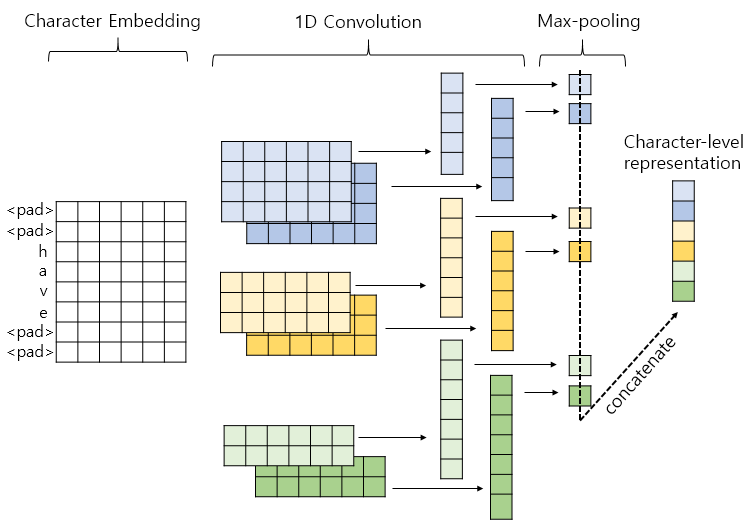)

위의 그림은 임의의 단어 'have'에 대해서 1D CNN을 통해서 단어 표현 벡터를 얻는 과정

<br>

1. **우선, 단어 'have'를 'h', 'a', 'v', 'e'와 같이 문자 단위로 분리**
2. **임베딩 층(Embedding layer)을 이용한 임베딩을 단어에 대해서 하는 것이 아니라 문자에 대해서 진행**
  - **다시 말해 문자를 임베딩**
  - **(문장의 길이를 맞추기 위해 패딩은 가능)**
3. **그 후 1D CNN을 적용**
  - **위의 그림은 커널의 사이즈가 4인 커널 2개, 3인 커널 2개, 2인 커널 2개를 사용할 때**
  - **벡터가 6개므로 맥스 풀링을 한 후에는 6개의 스칼라 값을 얻음**
4. **풒링을 통해 얻은 스칼라값들은 전부 연결(concatenate)하여 하나의 벡터로 생성**

5. **최종적으로 이렇게 얻은 벡터를 단어 의 벡터로 사용**

<br>

- 문자 레벨 표현(Character-level representation)이라고 기재된 벡터에 해당
- **이렇게 단어 벡터를 얻을 경우, 어떤 단어든 기본적으로 문자 레벨로 쪼개므로 기존 워드 임베딩의 접근에서 OOV라고 하더라도 벡터를 얻을 수 있음**
  - 가령, 'docker'라는 영단어가 훈련 데이터에 없었으나 테스트 데이터에 존재하는 단어였을 때,

    - Word2Vec이나 GloVe의 경우에는 OOV 문제가 발생

    - 1D CNN을 이용하는 경우에는 'd', 'o', 'c', 'k', 'e', 'r'로 전부 분리되어

      각 문자로 임베딩이 되고나서 1D CNN을 거친 후에 'docker'의 벡터를 얻음

<br>

### BiLSTM을 이용한 문자 임베딩

- **1D CNN과 마찬가지로 기본적으로 단어를 문자로 쪼갠 후, 임베딩 층을 사용하여 문자 임베딩을 입력으로 사용**

![bilstm[1].PNG](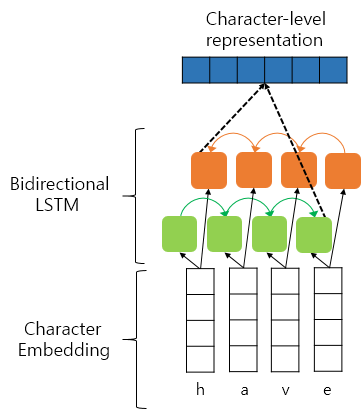)

위 그림은 임의의 단어 'have'에 대해서 BiLSTM을 통해서 단어 표현 벡터를 얻는 과정

<br>

1. **우선, 단어 'have'를 'h', 'a', 'v', 'e'와 같이 문자 단위로 분리**
2. **임베딩 층(Embedding layer)을 이용한 임베딩을 단어에 대해서 하는 것이 아니라 문자에 대해서 진행**
  - 문자를 임베딩하는 것
3. **순방향 LSTM은 단어 순방향으로 순차적으로 문자 임베딩 벡터를 읽음**

4. **역방향 LSTM은 단어의 역방향으로 순차적으로 문자 임베딩 벡터를 읽음**

5. **순방향 LSTM의 마지막 시점의 은닉 상태와 역방향 LSTM의 첫번째 시점의 은닉 상태를 연결(concatenate)**
6. **최종적으로 이렇게 얻은 벡터를 단어 'have'의 벡터로 사용**

<br>

**문자 임베딩을 워드 임베딩의 대체재로서 쓰거나, 문자 임베딩을 워드 임베딩과 연결(concatenate)하여 신경망의 입력으로 사용**